Segment Anything Model (SAM)
===

 * Paper: https://arxiv.org/abs/2304.02643

```bash
pip install torch torchvision
pip install transformers
pip install matplotlib
pip install supervision
```

In [1]:
import os
import numpy as np
from PIL import Image
import supervision as sv
import matplotlib.pyplot as plt
import torch
import torchvision
from transformers import SamModel, SamProcessor

device = "cuda" if torch.cuda.is_available() else "cpu"
model = SamModel.from_pretrained("facebook/sam-vit-huge").to(device)
processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")

In [2]:
def inference(image, points=None, boxes=None, device="cpu"):
    inputs = processor(
        image,
        input_points=points,
        input_boxes=boxes,
        return_tensors="pt"
    ).to(device)
    with torch.no_grad():
        outputs = model(**inputs)

    masks = processor.image_processor.post_process_masks(
        outputs.pred_masks.cpu(),
        inputs["original_sizes"].cpu(),
        inputs["reshaped_input_sizes"].cpu()
    )
    scores = outputs.iou_scores

    return masks, scores

In [3]:
image_path = "../samples/fruits-01.jpg"

image = Image.open(image_path).convert("RGB")

input_points = [[[1000, 1000]]]

masks, scores = inference(
    image, points=input_points, device=device
)

print("masks:", masks[0].shape)
print("scores:", scores.shape)

masks: torch.Size([1, 3, 2016, 1512])
scores: torch.Size([1, 1, 3])


In [4]:
from PIL import ImageDraw

def draw_points(image, points):
    draw = ImageDraw.Draw(image)
    r = 20
    for point in points:
        draw.ellipse(
            (point[0] - r, point[1] - r, point[0] + r, point[1] + r),
            fill="red",
            outline="red",
        )
    return image


def visualize_masks(image, masks, scores):
    bboxes = torchvision.ops.masks_to_boxes(masks[0])
    print("bboxes:", bboxes.shape)
    detections = sv.Detections(
        xyxy=bboxes.numpy(),
        confidence=scores[0, 0].cpu().numpy(),
        mask=masks[0].numpy(),
        class_id=np.array([0] * len(bboxes)),
    )
    annotator = sv.MaskAnnotator()
    annotated_image = annotator.annotate(
        scene=image,
        detections=detections,
    )

    return annotated_image

bboxes: torch.Size([3, 4])


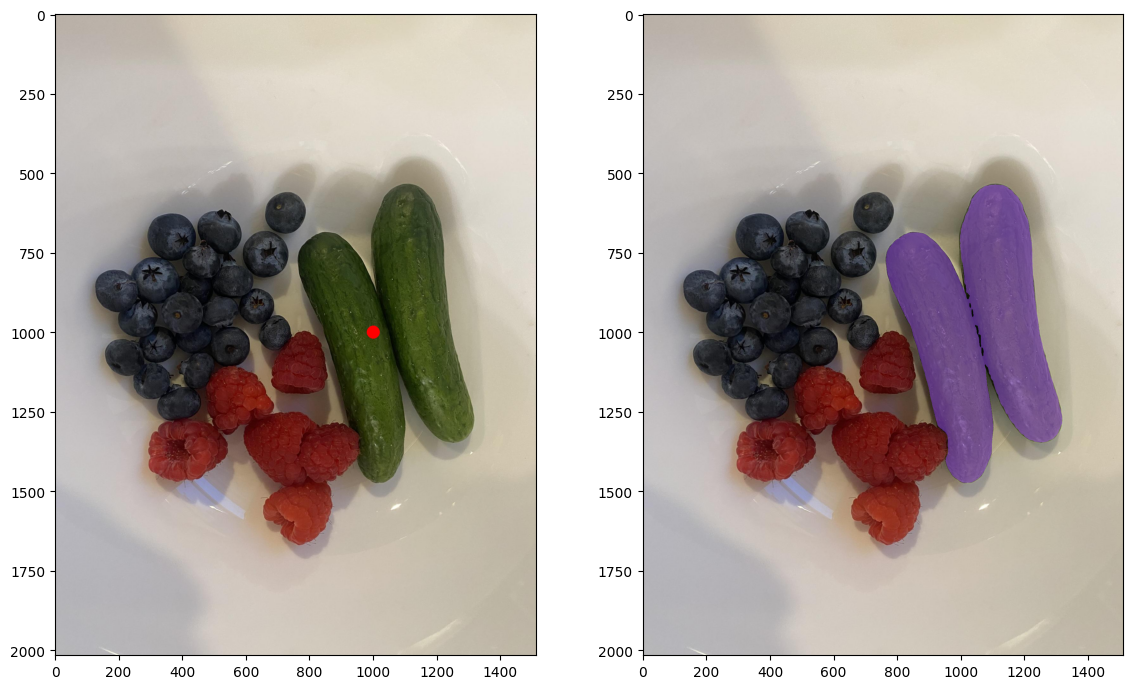

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(12, 7))
axes[0].imshow(draw_points(image.copy(), input_points[0]))
axes[1].imshow(visualize_masks(image.copy(), masks[0], scores))
plt.tight_layout()
plt.show()